# CSW MetaLearning Branch

The main (only) difference in CSWML is the inclusion of pr_shift as a pararmeter which controls stimulus generation. otherwise it is the same as backpropagating manystories.

In [49]:
import numpy as np
from glob import glob as glob

from cswsims import *
import tensorflow as tf

from matplotlib import pyplot as plt
%matplotlib inline

%load_ext autoreload
%reload_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# load data

In [3]:
evalD = {}
# trainD = {}
# dtype and shape for array
mdirL = glob('models/models/sweep_shiftpr/state*/*/eval*.npy')
for mdir in mdirL:
  mdir = "/".join(mdir.split('/')[:-1])
  shiftpr = int(mdir.split('/')[-2].split('_')[-1])
  if shiftpr not in evalD: evalD[shiftpr] = []
#   if shiftpr not in trainD: trainD[shiftpr] = []
#   trainD[shiftpr].append(np.load(mdir+'/train_data.npy'))
  evalD[shiftpr].append(np.load(mdir+'/eval_data.npy'))
evalD = {k:np.array(v) for k,v in evalD.items()}
# trainD = {k:np.array(v) for k,v in trainD.items()}

In [3]:
# evalD = {}
# trainD = {}
# # dtype and shape for array
# mdir0=glob('models/models/sweep_shiftpr/state*/*/*.npy')[0]
# mdir0 = "/".join(mdir0.split('/')[:-1])
# eval_dtype = np.load(mdir0+'/eval_data.npy').dtype
# train_dtype = np.load(mdir0+'/train_data.npy').dtype
# nepochs = len(np.load(mdir0+'/train_data.npy'))
# mdirL = glob('models/models/sweep_shiftpr/state*')
# # load train and eval data 
# for mdir in mdirL:
# #   print(mdir)
#   shiftpr = int(mdir.split('_')[-1])
#   subdirL = glob(mdir+'/*')
#   nmodels = len(subdirL)
#   evalD[shiftpr] = []
#   trainD[shiftpr] = np.ones([nmodels,nepochs],dtype=train_dtype)*100
#   for sidx,subdir in enumerate(subdirL):
# #     print(subdir)
#     try:
# #       evalD[shiftpr][sidx] = np.load(subdir+'/eval_data.npy')
#       eval_arr = np.load(subdir+'/eval_data.npy')
#       evalD[shiftpr].append(eval_arr)
#       trainD[shiftpr][sidx] = np.load(subdir+'/train_data.npy')
#     except:
#       print('passing',subdir)
#       pass

# train data

## predictions

In [10]:
evalseq = [
10, 0, 2, 4, 6, 8, 9, 
11, 0, 2, 3, 6, 7, 9,
10, 0, 2, 4, 6, 8, 9]

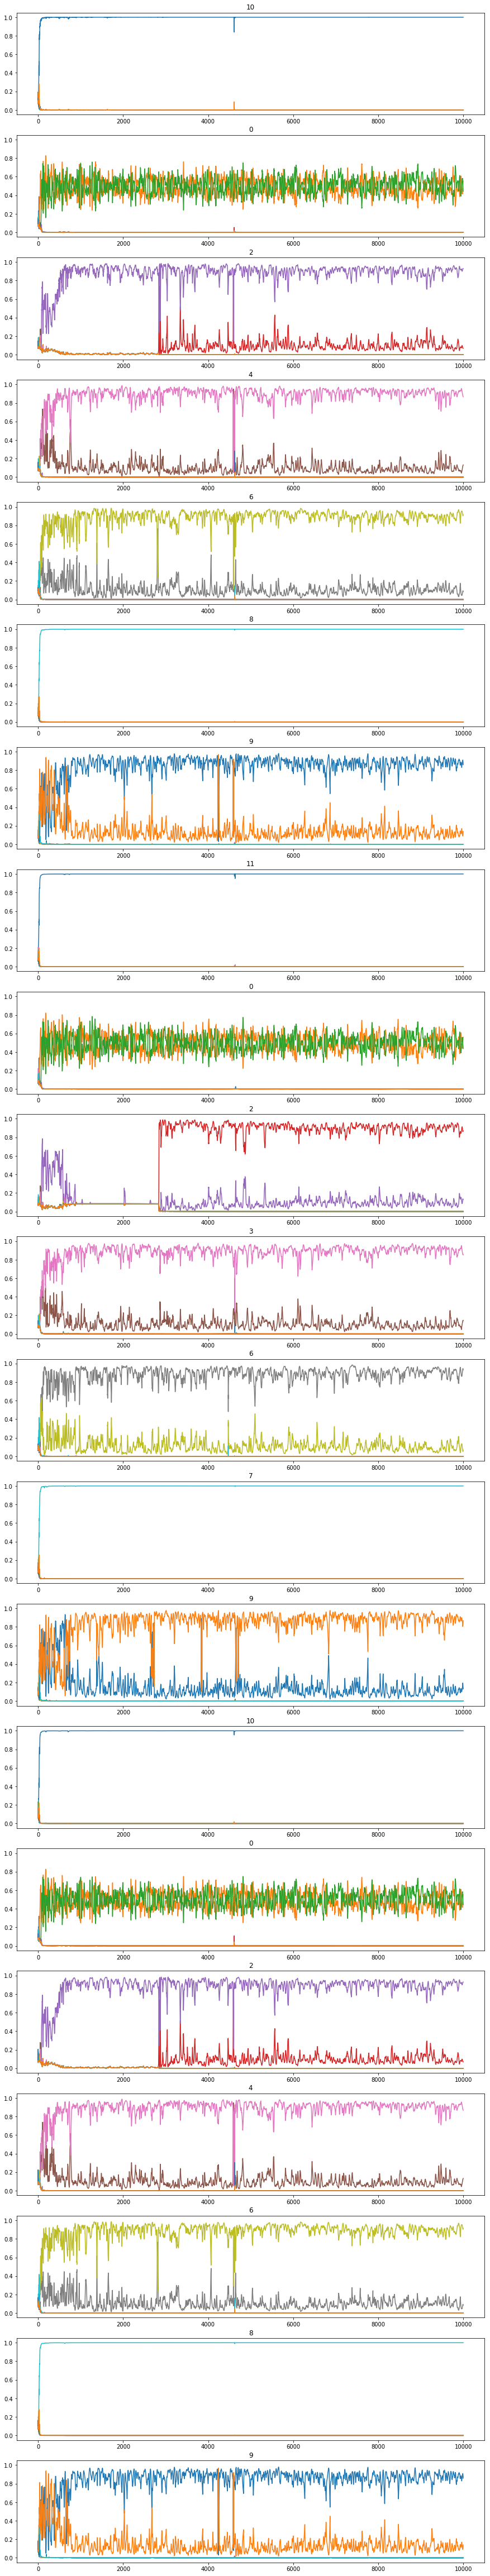

In [11]:
shiftpr = 10

d = 21
fig,axarr = plt.subplots(d,1,figsize=(15,4*d))

# mean over sub dim and squeeze batch dim
# M = trainD[shiftpr]['yhat'].mean((0,2))

subj = 0
M = trainD[shiftpr]['yhat'].squeeze()[subj]

for depth,ax in enumerate(axarr):
#   story = 0
#   transition = -3
#   depth = 7*story + transition
#   print(depth)
  frnode = evalseq[depth]
  ax.plot(M[:,depth,:])
  ax.set_ylim(-.05,1.05)
  ax.set_title(frnode)

# eval data

In [ ]:
seqL = ['AAA','AAB','ABA','ABB',
        'BAA','BAB','BBA','BBB']

## fgate analysis
- there are two parts to this analysis:
- part 1: basic statistics of fgate activation across neurons 
    - fgates sync up at low levels at beginning of sequence
- part 2: fgate modulation due to context-sequence congruence and training regime
    - no effect
    - suspect this is because networks are developing tensor-product representations

### mean fgate act

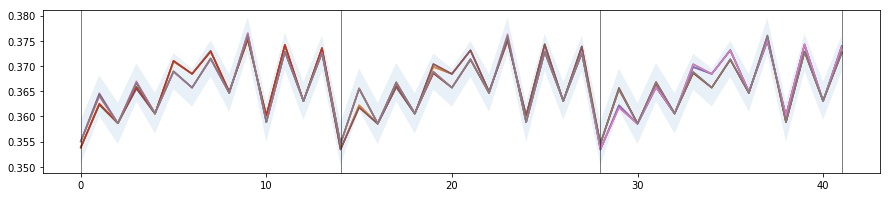

In [6]:
shiftpr=10

plt.figure(figsize=(15,3))
ax = plt.gca()

for seq in seqL:
  net_fgate_act = evalD[shiftpr][seq]['fgate'].squeeze().mean(2)
  M = net_fgate_act.mean(0)
  S = net_fgate_act.std(0)/np.sqrt(len(net_fgate_act))
  ax.plot(M,label=shiftpr)

# use stderr of single sequence
ax.fill_between(range(len(M)),M-S,M+S,alpha=.1)

for t in range(0,42,14):
  ax.axvline(t,c='black',lw=.5)
ax.axvline(41,c='black',lw=.5)


# plt.savefig('figures/fgate mean act overlaid')

- no change in fgate activation with respect to sequence
- fgate activation starts low at beginning of sequence and increases over the sequence. Is this because flag presented at beginning of sequence conveys most information / 'transports' network to a region from which it can evolve into A or B context?
- note zigzag on in/out computation steps

### variance across neurons in fgate act

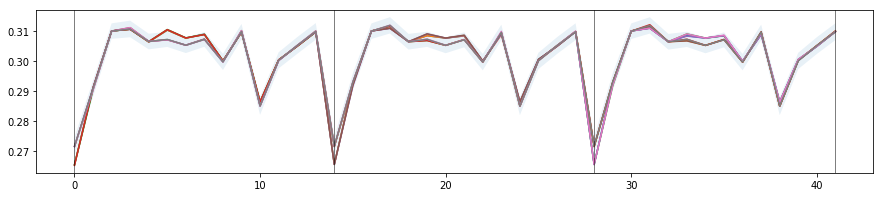

In [7]:
net_std_fun = lambda shiftpr,seq: evalD[shiftpr][seq]['fgate'].squeeze().std(2)

plt.figure(figsize=(15,3))
ax = plt.gca()

# standard deviation of fgate across units for each net
for seq in seqL:
  net_std = net_std_fun(shiftpr,seq)
  M = net_std.mean(0)
  S = net_std.std(0)/np.sqrt(len(net_std))
  ax.plot(M,label=shiftpr)
    
ax.fill_between(range(len(M)),M-S,M+S,alpha=.1)
for t in [0,14,28,41]:
  ax.axvline(t,c='black',lw=.5)

# plt.legend()
# plt.savefig('figures/fgate var across units overlaid')

- fgate activation is syncing up across neurons at beginning of sequence 

### diff in overall fgate activity
- no effect of training regime

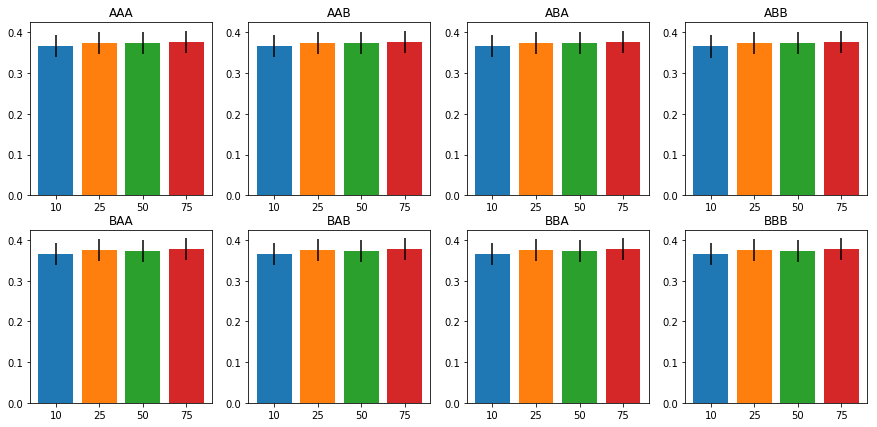

In [4]:
fig,axarr = plt.subplots(2,4,figsize=(15,7)); axarr=axarr.reshape(-1)
for ax,seq in zip(axarr,seqL):
  for idx,shiftpr in enumerate([10,25,50,75]):
    fgate_arr = evalD[shiftpr][seq]['fgate']
    M = fgate_arr.mean()
    S = fgate_arr.std() / np.sqrt(len(fgate_arr))
    ax.bar(idx,M,yerr=S)
  ax.set_title(seq)
  ax.set_xticklabels([0,10,25,50,75])
# plt.savefig('figures/mean_fgate_activation')

### context modulation
- no effect of context-sequence congruence or training regime

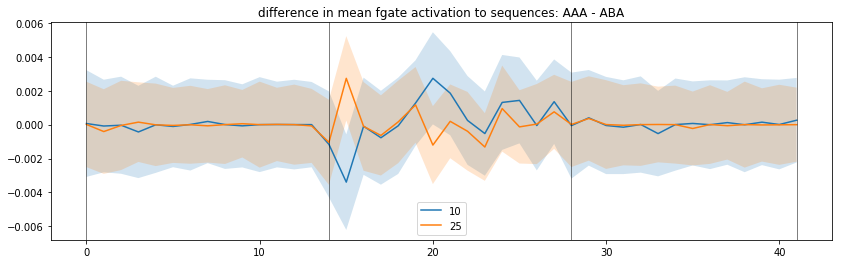

In [65]:
plt.figure(figsize=(14,4))
seq1,seq2 = ['AAA','ABA']

for shiftpr in [10,25]:
  eval_data = evalD[shiftpr]
  fgate_act = lambda seq: eval_data[seq]['fgate'].mean((0,1,3))
  fgate_std = eval_data[seq1]['fgate'].mean((1,3)).std(0) / np.sqrt(250)
  fgate_diff = (fgate_act(seq1) - fgate_act(seq2))
  plt.plot(fgate_diff,label=shiftpr)
  plt.fill_between(np.arange(len(fgate_diff)),fgate_diff-fgate_std,fgate_diff+fgate_std,alpha=.2)

plt.legend()
for t in range(0,42,14):
  plt.axvline(t,c='black',lw=.5)
plt.axvline(41,c='black',lw=.5)

plt.title('difference in mean fgate activation to sequences: AAA - ABA')
# plt.savefig('figures/context_modulation_stderr_prob')

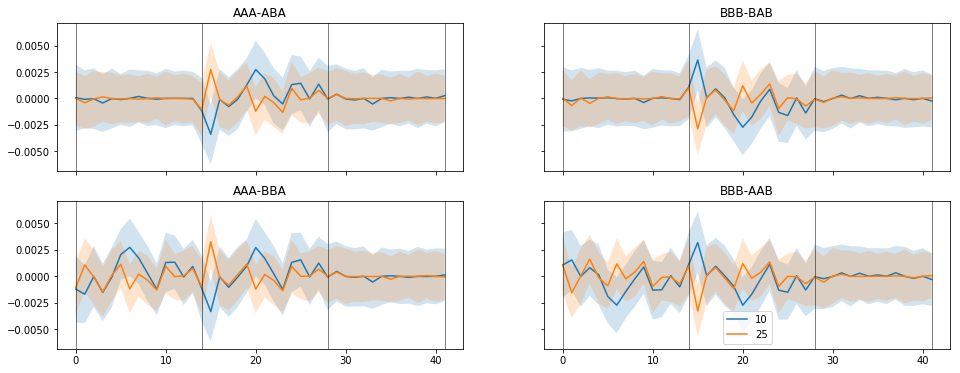

In [9]:
seq12L = [
  ['AAA','ABA'],['BBB','BAB'],
  ['AAA','BBA'],['BBB','AAB'],
  
#   ['BAA','ABA'],['BAA','BBA'],
#   ['ABB','BAB'],['AAA','AAB']
]

fig,axarr = plt.subplots(2,2,figsize=(16,6),sharex=True,sharey=True); axarr=axarr.reshape(-1)
for ax,(seq1,seq2) in zip(axarr,seq12L):
  for shiftpr in [10,25]:
    eval_data = evalD[shiftpr]
    fgate_act = lambda seq: eval_data[seq]['fgate'].mean((0,1,3))
    fgate_std = eval_data[seq1]['fgate'].mean((1,3)).std(0) / np.sqrt(250)
    fgate_diff = (fgate_act(seq1) - fgate_act(seq2))
    ax.set_title("%s-%s"%(seq1,seq2))
    ax.plot(fgate_diff,label=shiftpr)
    ax.fill_between(np.arange(len(fgate_diff)),fgate_diff-fgate_std,fgate_diff+fgate_std,alpha=.2)

  for t in range(0,42,14):
    ax.axvline(t,c='black',lw=.5)
  ax.axvline(41,c='black',lw=.5)

axarr[-1].legend()
# plt.sup_title('difference in mean fgate activation to sequences: AAA - ABA')
plt.savefig('figures/fullseq_context_modulation_stderr_prob')

### interim summary
- i was expecting but didn't find any effects of fgate above. 
- current working hypothesis is that networks are developing tensor product representations, which means the fgate is not using to "flush incorrect" context.  

## RSA on state vector

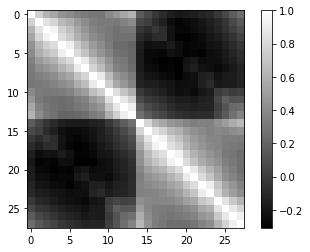

In [8]:
## full matrix

shiftpr = 10

seq1,seq2 = 'AAA','BBB'

# compute mean RSM
def meanRSM(net_state_arr):
  ntime = net_state_arr.shape[1]
  meanRSM = np.zeros([ntime,ntime])
  for net_state in net_state_arr:
    netRSM = np.corrcoef(net_state)
    meanRSM += netRSM/len(net_state_arr)
  return meanRSM

state_arr_A = evalD[shiftpr][seq1]['states'].squeeze()[:,-14:,:]
state_arr_B = evalD[shiftpr][seq2]['states'].squeeze()[:,-14:,:]
state_arr_AB = np.concatenate([state_arr_A,state_arr_B],1)

RSMA = meanRSM(state_arr_A)
RSMB = meanRSM(state_arr_B)
RSMAB = meanRSM(state_arr_AB)

plt.imshow(RSMAB,cmap='gray'); plt.colorbar()
# plt.savefig('figures/RSM AB full')

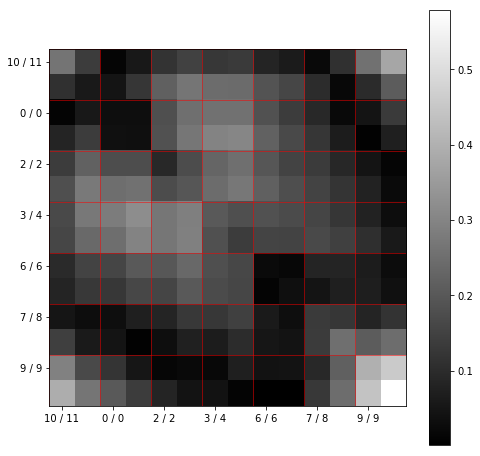

In [410]:
## offblock 

inlab = ["10 / 11", "0 / 0", "2 / 2", "3 / 4", "6 / 6", "7 / 8", "9 / 9"]

plt.figure(figsize=(8,8))
RSM_plot = np.abs(RSMAB[:14,-14:])
# RSM_plot = RSMAB
plt.imshow(RSM_plot,cmap='gray')
plt.colorbar()
plt.xticks(range(0,14,2),inlab)
plt.yticks(range(0,14,2),inlab)

for t in range(0,14,2):
  plt.axvline(t-.5,c='r',lw=.5)
  plt.axhline(t-.5,c='r',lw=.5)

# plt.savefig('figures/RSM AB cell similarity ')

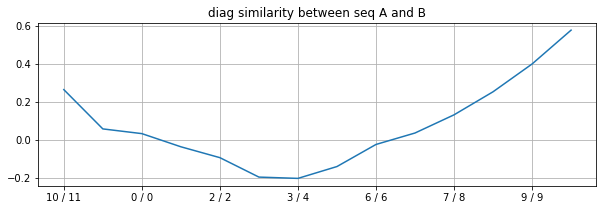

In [411]:
### diag

plt.figure(figsize=(10,3))
plt.xticks(range(0,14,2),inlab)

RSM_plot = RSMAB[:14,-14:]
plt.plot(np.diag(RSM_plot,0))
plt.grid()
plt.title('diag similarity between seq A and B')
# plt.savefig('figures/diag AB cell similarity')

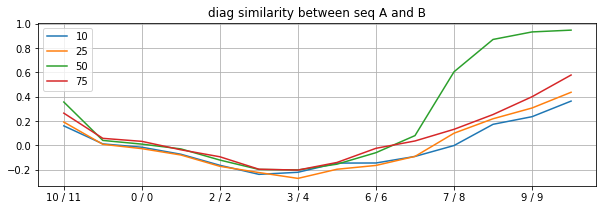

In [412]:
plt.figure(figsize=(10,3))
plt.xticks(range(0,14,2),inlab)

seq1,seq2='AAA','BBB'
for shiftpr in [10,25,50,75]:
  state_arr_A = evalD[shiftpr][seq1]['states'].squeeze()[:,-14:,:]
  state_arr_B = evalD[shiftpr][seq2]['states'].squeeze()[:,-14:,:]
  state_arr_AB = np.concatenate([state_arr_A,state_arr_B],1)
  RSMAB = meanRSM(state_arr_AB)
  RSM_plot = RSMAB[:14,-14:]
  plt.plot(np.diag(RSM_plot,0),label=shiftpr)

plt.grid()
plt.legend()
plt.title('diag similarity between seq A and B')
plt.savefig('figures/diag AB cell similarity, across prshifts')

### tensor-product or shared representation?
- similarity measure
- parrellel score

In [147]:
import itertools

context_strL=["".join(i) for i in itertools.product(
                                    ('A1','A2','B1','B2'),
                                    ('A1','A2','B1','B2'),
                                    ('A1','A2','B1','B2')
                                   )]

for shiftpr in [10,50,90]:
  for idx in range(1):
    midx = "%.3i"%idx
    fpath = 'models/sweep_shiftpr/state_50-nstories_3-shiftpr_%i/%s/trained' %(shiftpr,midx)
    ML.saver_op.restore(ML.sess,fpath)
    trainer = Trainer(ML,0.5,0.9)
    eval_data = trainer.eval_loop(context_strL)
    np.save()
    

In [51]:
# ML = MetaLearner(50,3)



INFO:tensorflow:Restoring parameters from models/sweep_shiftpr/state_50-nstories_3-shiftpr_50/000/trained


## trajectory in state space

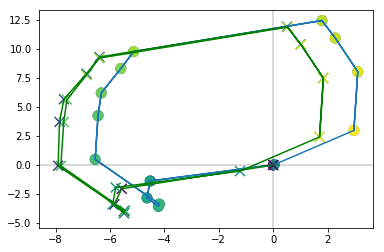

In [387]:
ax = plt.gca()
shiftpr=50
net=10
stA = evalD[shiftpr]['AAA']['states'].squeeze()[net]
stB = evalD[shiftpr]['BAA']['states'].squeeze()[net]

st_pc = PCA(2).fit_transform(np.concatenate([stA,stB]))
stA_pc = st_pc[:int(len(st_pc)/2)]
stB_pc = st_pc[-int(len(st_pc)/2):]
s=28
stA_pc = stA_pc[-s:]
stB_pc = stB_pc[-s:]
stA_pc -= stA_pc[0]
stB_pc -= stB_pc[0]

ax.scatter(stA_pc[:,0],stA_pc[:,1],marker='o',s=100,c=range(len(stA_pc)),cmap='viridis')
ax.plot(stA_pc[:,0],stA_pc[:,1])
ax.scatter(stB_pc[:,0],stB_pc[:,1],marker='x',s=100,c=range(np.abs(s)),cmap='viridis')
ax.plot(stB_pc[:,0],stB_pc[:,1],c='g')

ax.axvline(0,lw=.3,c='black')
ax.axhline(0,lw=.3,c='black')

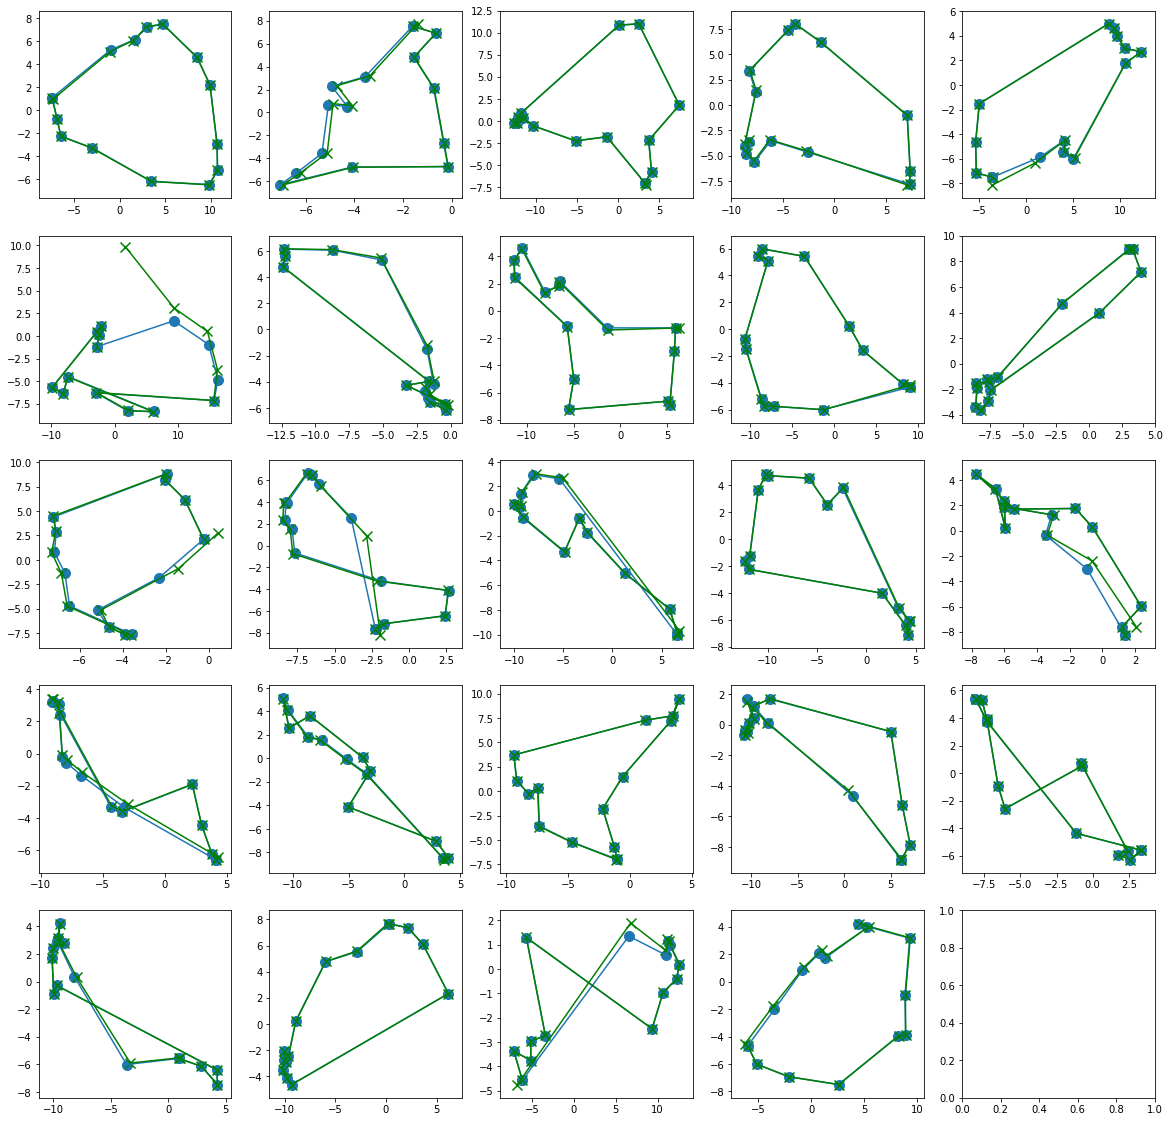

In [426]:
from sklearn.decomposition import PCA

shiftpr=50

# fig,axarr = plt.subplots(12,2,figsize=(10,75))
fig,axarr = plt.subplots(5,5,figsize=(20,20))

Aseq,Bseq = 'AAA','BBA'
for net in range(24):
  ax = axarr.reshape(-1)[net]
  stA = evalD[shiftpr][Aseq]['states'].squeeze()[net]
  stB = evalD[shiftpr][Bseq]['states'].squeeze()[net]

  st_pc = PCA(2).fit_transform(np.concatenate([stA,stB]))
  stA_pc = st_pc[:int(len(st_pc)/2)]
  stB_pc = st_pc[-int(len(st_pc)/2):]
  s=-15
  stA_pc = stA_pc[s:]
  stB_pc = stB_pc[s:]

  ax.scatter(stA_pc[:,0],stA_pc[:,1],marker='o',s=100)
  ax.plot(stA_pc[:,0],stA_pc[:,1])
  ax.scatter(stB_pc[:,0],stB_pc[:,1],marker='x',s=100,c='g')
  ax.plot(stB_pc[:,0],stB_pc[:,1],c='g')

  
# ax.colorbar()
plt.savefig('figures/state PCA traj - 25 nets - %s,%s'%(Aseq,Bseq))

### svm analyses

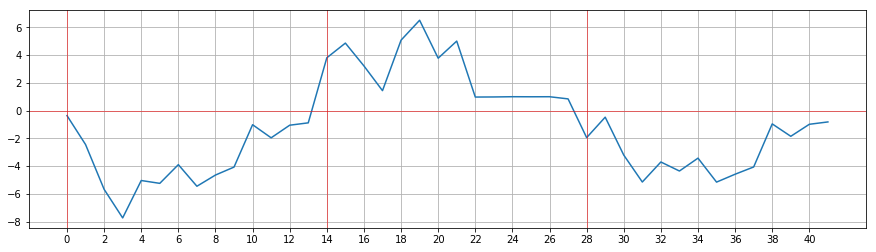

In [465]:
from sklearn.svm import LinearSVC

shiftpr=50
fit_statesA = evalD[shiftpr]['AAA']['states'].squeeze()
fit_statesB = evalD[shiftpr]['BBB']['states'].squeeze()

net = 3
X = np.concatenate([fit_statesA[net],fit_statesB[net]])
Y = np.concatenate([np.ones(int(len(X)/2)),np.zeros(int(len(X)/2))])
svm = LinearSVC()
svm.fit(X,Y)

plt.figure(figsize=(15,4))
eval_states = evalD[shiftpr]['BAB']['states'].squeeze()[net]

plt.plot(svm.decision_function(eval_states))
for t in np.arange(0,42,14):
  plt.axvline(t,c='r',lw=.5)
plt.axhline(0,c='r',lw=.5)
plt.xticks(range(0,42,2))
plt.grid()

plt.savefig('figures/SVM - distance to hyperplane trAAA-BBB teBAB')